In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.metrics import (f1_score, precision_score, recall_score,
                             accuracy_score, classification_report,
                             roc_curve, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, RocCurveDisplay)

In [ ]:
students = "./data/studentdras.csv"

In [ ]:
students_df = pd.read_csv(students)

In [ ]:
students_df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [ ]:
X_data = students_df.drop('Target', axis=1)

y_data = students_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3539, 36)
(885, 36)
(3539,)
(885,)


In [ ]:
n_trees = [400, 600, 800]
sqrt_n_features = sqrt(X_train.shape[1])
max_depths = [(int)(0.5*sqrt_n_features), (int)(sqrt_n_features), (int)(2*sqrt_n_features)]
best_model = None
best_oob = 0
for trees in n_trees:
    print("============================================")
    for depth in max_depths:
        clf = RandomForestClassifier(n_estimators=trees, max_depth=depth, random_state=42, oob_score=True)
        clf.fit(X_train, y_train)
        oob_score = clf.oob_score_
        if best_oob < oob_score:
            best_model = clf
            best_oob = oob_score
        print(f"Trees: {trees}, Max Depth: {depth}, OOB Score: {oob_score:.3f}")
print("============================================")
print(f"Best OOB Score: {best_oob:.3f}")

Trees: 400, Max Depth: 3, OOB Score: 0.724
Trees: 400, Max Depth: 6, OOB Score: 0.759
Trees: 400, Max Depth: 12, OOB Score: 0.773
Trees: 600, Max Depth: 3, OOB Score: 0.725
Trees: 600, Max Depth: 6, OOB Score: 0.760
Trees: 600, Max Depth: 12, OOB Score: 0.773
Trees: 800, Max Depth: 3, OOB Score: 0.724
Trees: 800, Max Depth: 6, OOB Score: 0.759
Trees: 800, Max Depth: 12, OOB Score: 0.775
Best OOB Score: 0.775


In [ ]:
cv_scores = cross_val_score(best_model, X_data, y_data, cv=3)

Cross-validation scores: [0.77627119 0.77288136 0.77001357]
Mean CV score: 0.773
F1 Score: 0.6802494202303629
Accuracy:0.774


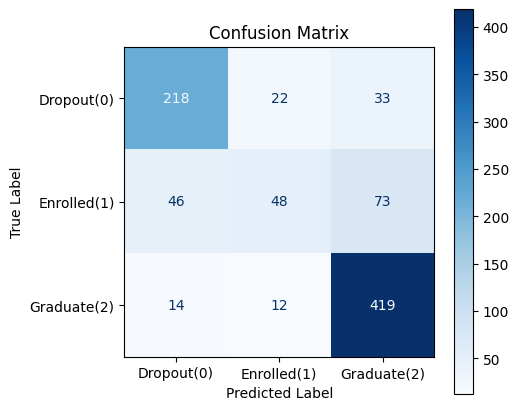

In [ ]:
print("Cross-validation scores:", cv_scores)

print(f"Mean CV score: {cv_scores.mean():.3f}")

y_pred = best_model.predict(X_test)
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy:{accuracy_score(y_test, y_pred):.3f}")

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Dropout(0)","Enrolled(1)", "Graduate(2)"]
)

fig,ax = plt.subplots(figsize=(5,5))
cm_display.plot(
    cmap=plt.cm.Blues,
    ax=ax,
    values_format='d'
)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.grid(False)
plt.show()

In [ ]:
gini_importances = best_model.feature_importances_

gini_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Gini Importance': gini_importances
})

gini_df = gini_df.sort_values(by='Gini Importance', ascending=False)

In [ ]:
mda_importances = []
initial_accuracy = accuracy_score(y_test, y_pred)
for i in range(X_data.shape[1]):
    X_test_copy = X_test.copy()
    # Shuffle the values in the specified feature column
    shuffled_column_values = X_test_copy.iloc[:, i].values.copy()
    np.random.shuffle(shuffled_column_values)
    X_test_copy.iloc[:, i] = shuffled_column_values

    shuff_accuracy = accuracy_score(y_test, clf.predict(X_test_copy))
    mda_importances.append(initial_accuracy - shuff_accuracy)

mda_df = pd.DataFrame({'Feature': X_data.columns, 'Decrease in Accuracy': mda_importances}).sort_values('Decrease in Accuracy', ascending=False)

/tmp/ipython-input-31-3811283367.py:12: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()


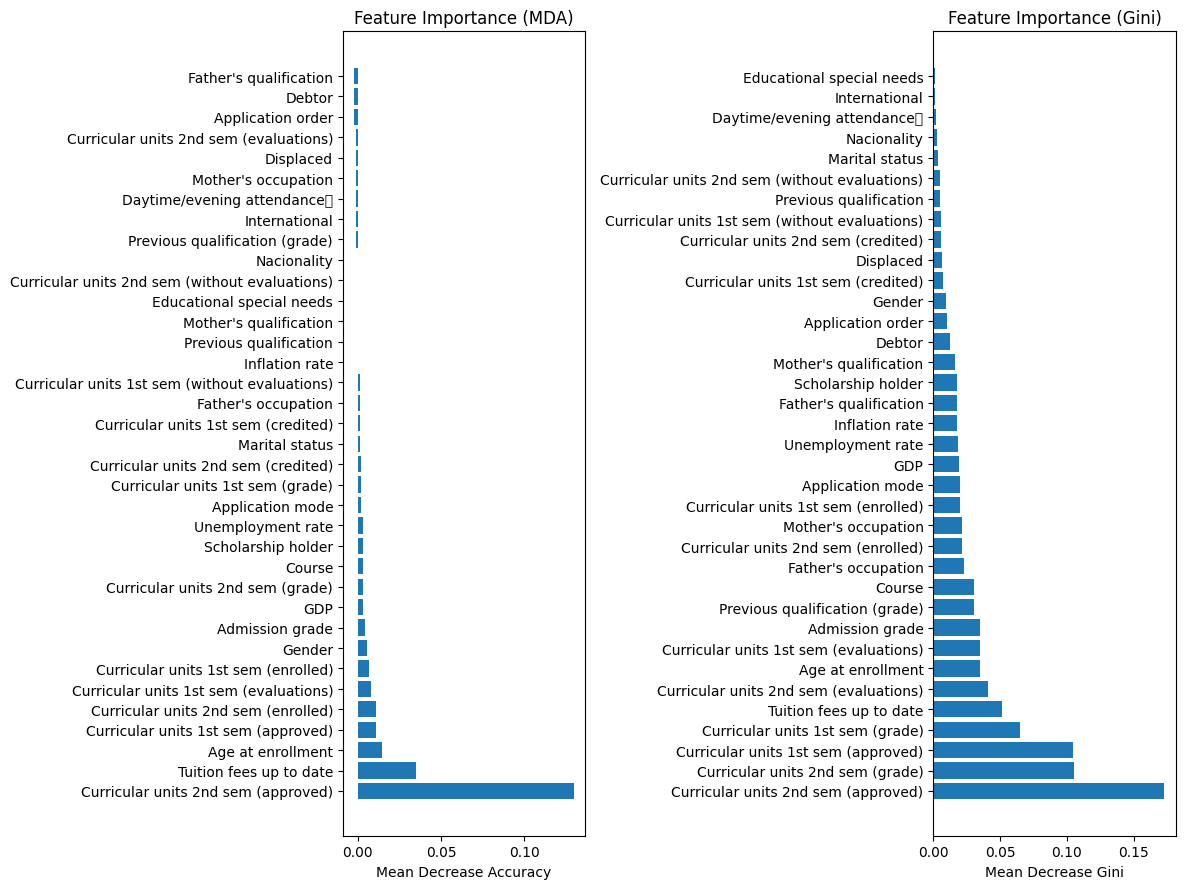

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))

ax1.barh(mda_df['Feature'], mda_df['Decrease in Accuracy'])
ax1.set_title('Feature Importance (MDA)')
ax1.set_xlabel('Mean Decrease Accuracy')

ax2.barh(gini_df['Feature'], gini_df['Gini Importance'])
ax2.set_title('Feature Importance (Gini)')
ax2.set_xlabel('Mean Decrease Gini')

plt.tight_layout()
plt.show()

In [34]:
print("Lets go Team 6!")

Lets go Team 6!
